In [1]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
%%R
data_folder = '../datasets/ups1_quantms/unique_peptide_target_only_psm0.01_prot0.01'
setwd(data_folder)

In [4]:
quantms = pd.read_csv("./out_msstats.csv", sep=',', header=0)
quantms = quantms[-quantms['ProteinName'].str.contains("DECOY_")]
print(len(set(quantms['ProteinName'])))
quantms.head()


1173


,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,Reference
0,sp|P04147|PABP_YEAST,.(Acetyl)ADITDKTAEQLENLNIQDDQK,3,NaN,0,L,UPS1|500 amol,8,23,34183840.0,UPS1_500amol_R2.mzML
1,sp|Q01519|COX12_YEAST,.(Acetyl)ADQENSPLHTVGFDAR,2,NaN,0,L,UPS1|12500 amol,1,1,28307620.0,UPS1_12500amol_R1.mzML
2,sp|Q01519|COX12_YEAST,.(Acetyl)ADQENSPLHTVGFDAR,2,NaN,0,L,UPS1|2500 amol,4,10,24355470.0,UPS1_2500amol_R1.mzML
3,sp|Q01519|COX12_YEAST,.(Acetyl)ADQENSPLHTVGFDAR,2,NaN,0,L,UPS1|2500 amol,4,11,24121910.0,UPS1_2500amol_R2.mzML
4,sp|Q01519|COX12_YEAST,.(Acetyl)ADQENSPLHTVGFDAR,2,NaN,0,L,UPS1|250 amol,5,14,20445250.0,UPS1_250amol_R2.mzML


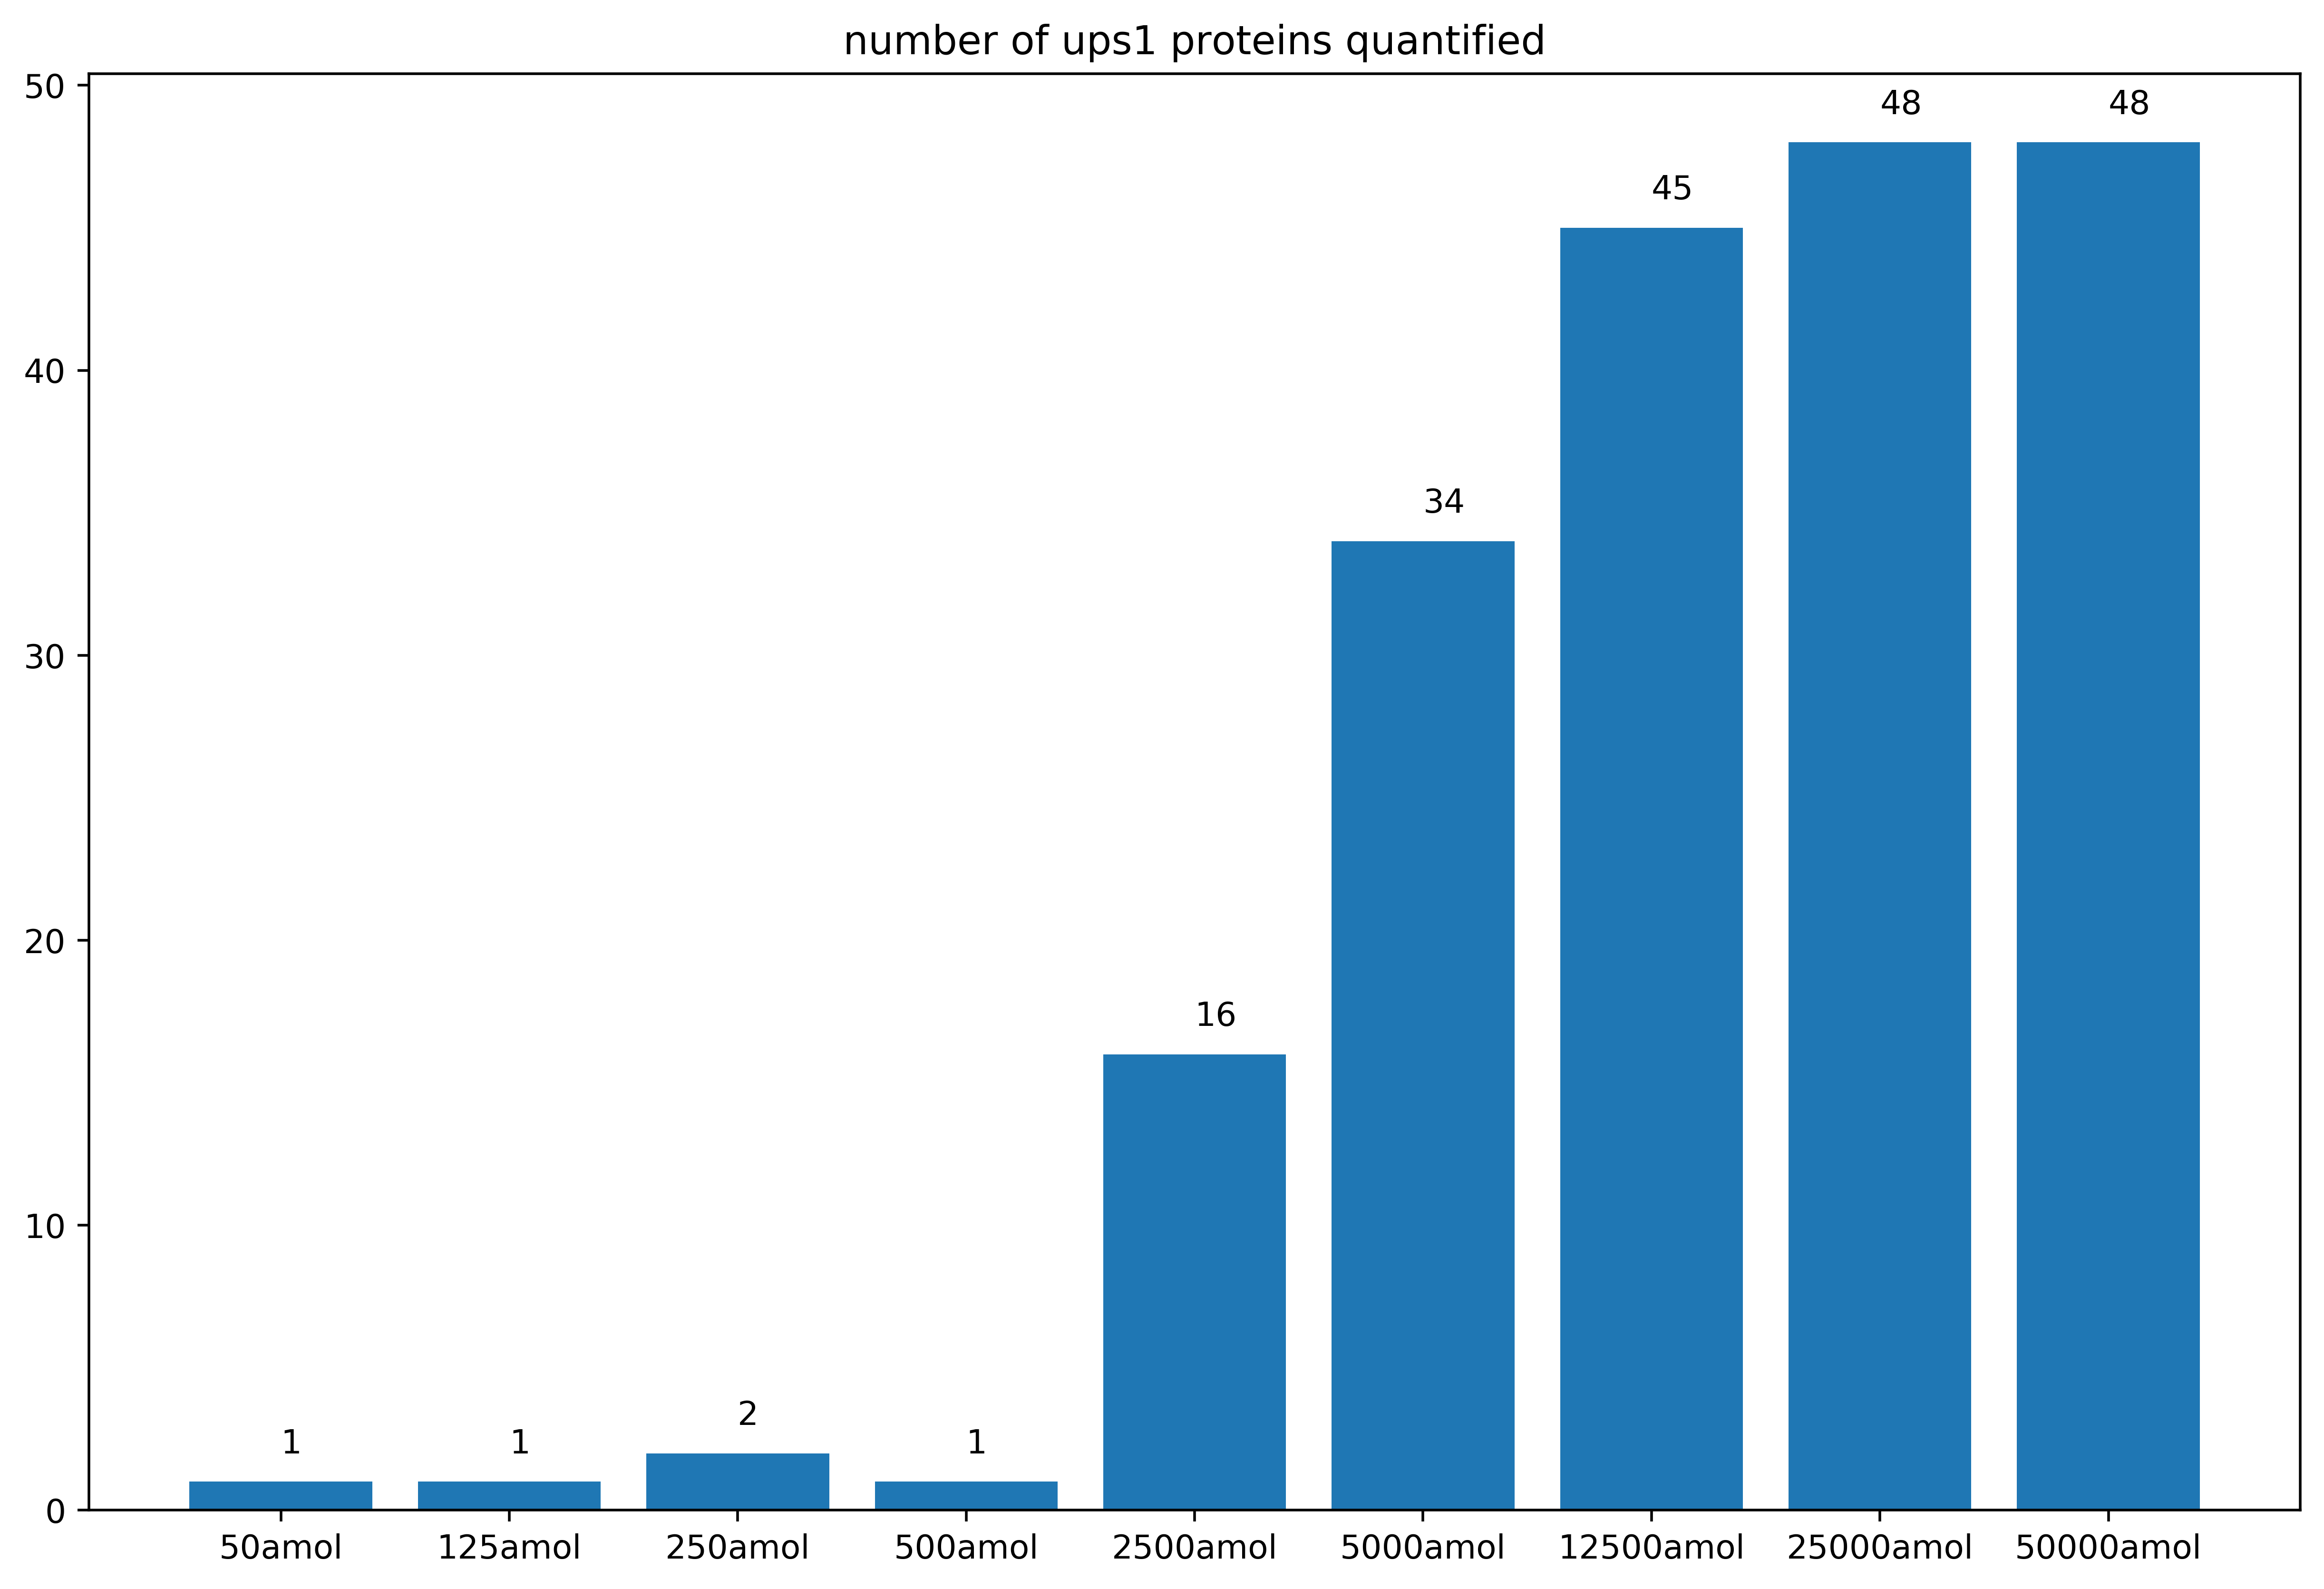

In [7]:
number_of_ups1 = dict()
for condition in np.unique(quantms['Condition']):
    number_of_ups1[condition.replace("UPS1|", "").replace(" ", "")] = len((set(quantms.loc[(quantms['ProteinName'].str.contains("ups")) & (quantms['Condition'] == condition), 'ProteinName'])))

plt.figure(figsize=(12,8), dpi=500)
num = []
label = []
for key, value in sorted(number_of_ups1.items(), key=lambda item: int(item[0].replace("amol",""))):
    num.append(value)
    label.append(key)
for x, y in zip(range(9), num):
    plt.text(x, y+1, y)

plt.bar(range(9), num)
plt.title("number of ups1 proteins quantified")
plt.xticks(range(9),label)
plt.show()

### Reproducibility between Analytical Replicate before msstats process

#### UPS1 CV . Filtered out missing ups1 protein but not fill or Imputation

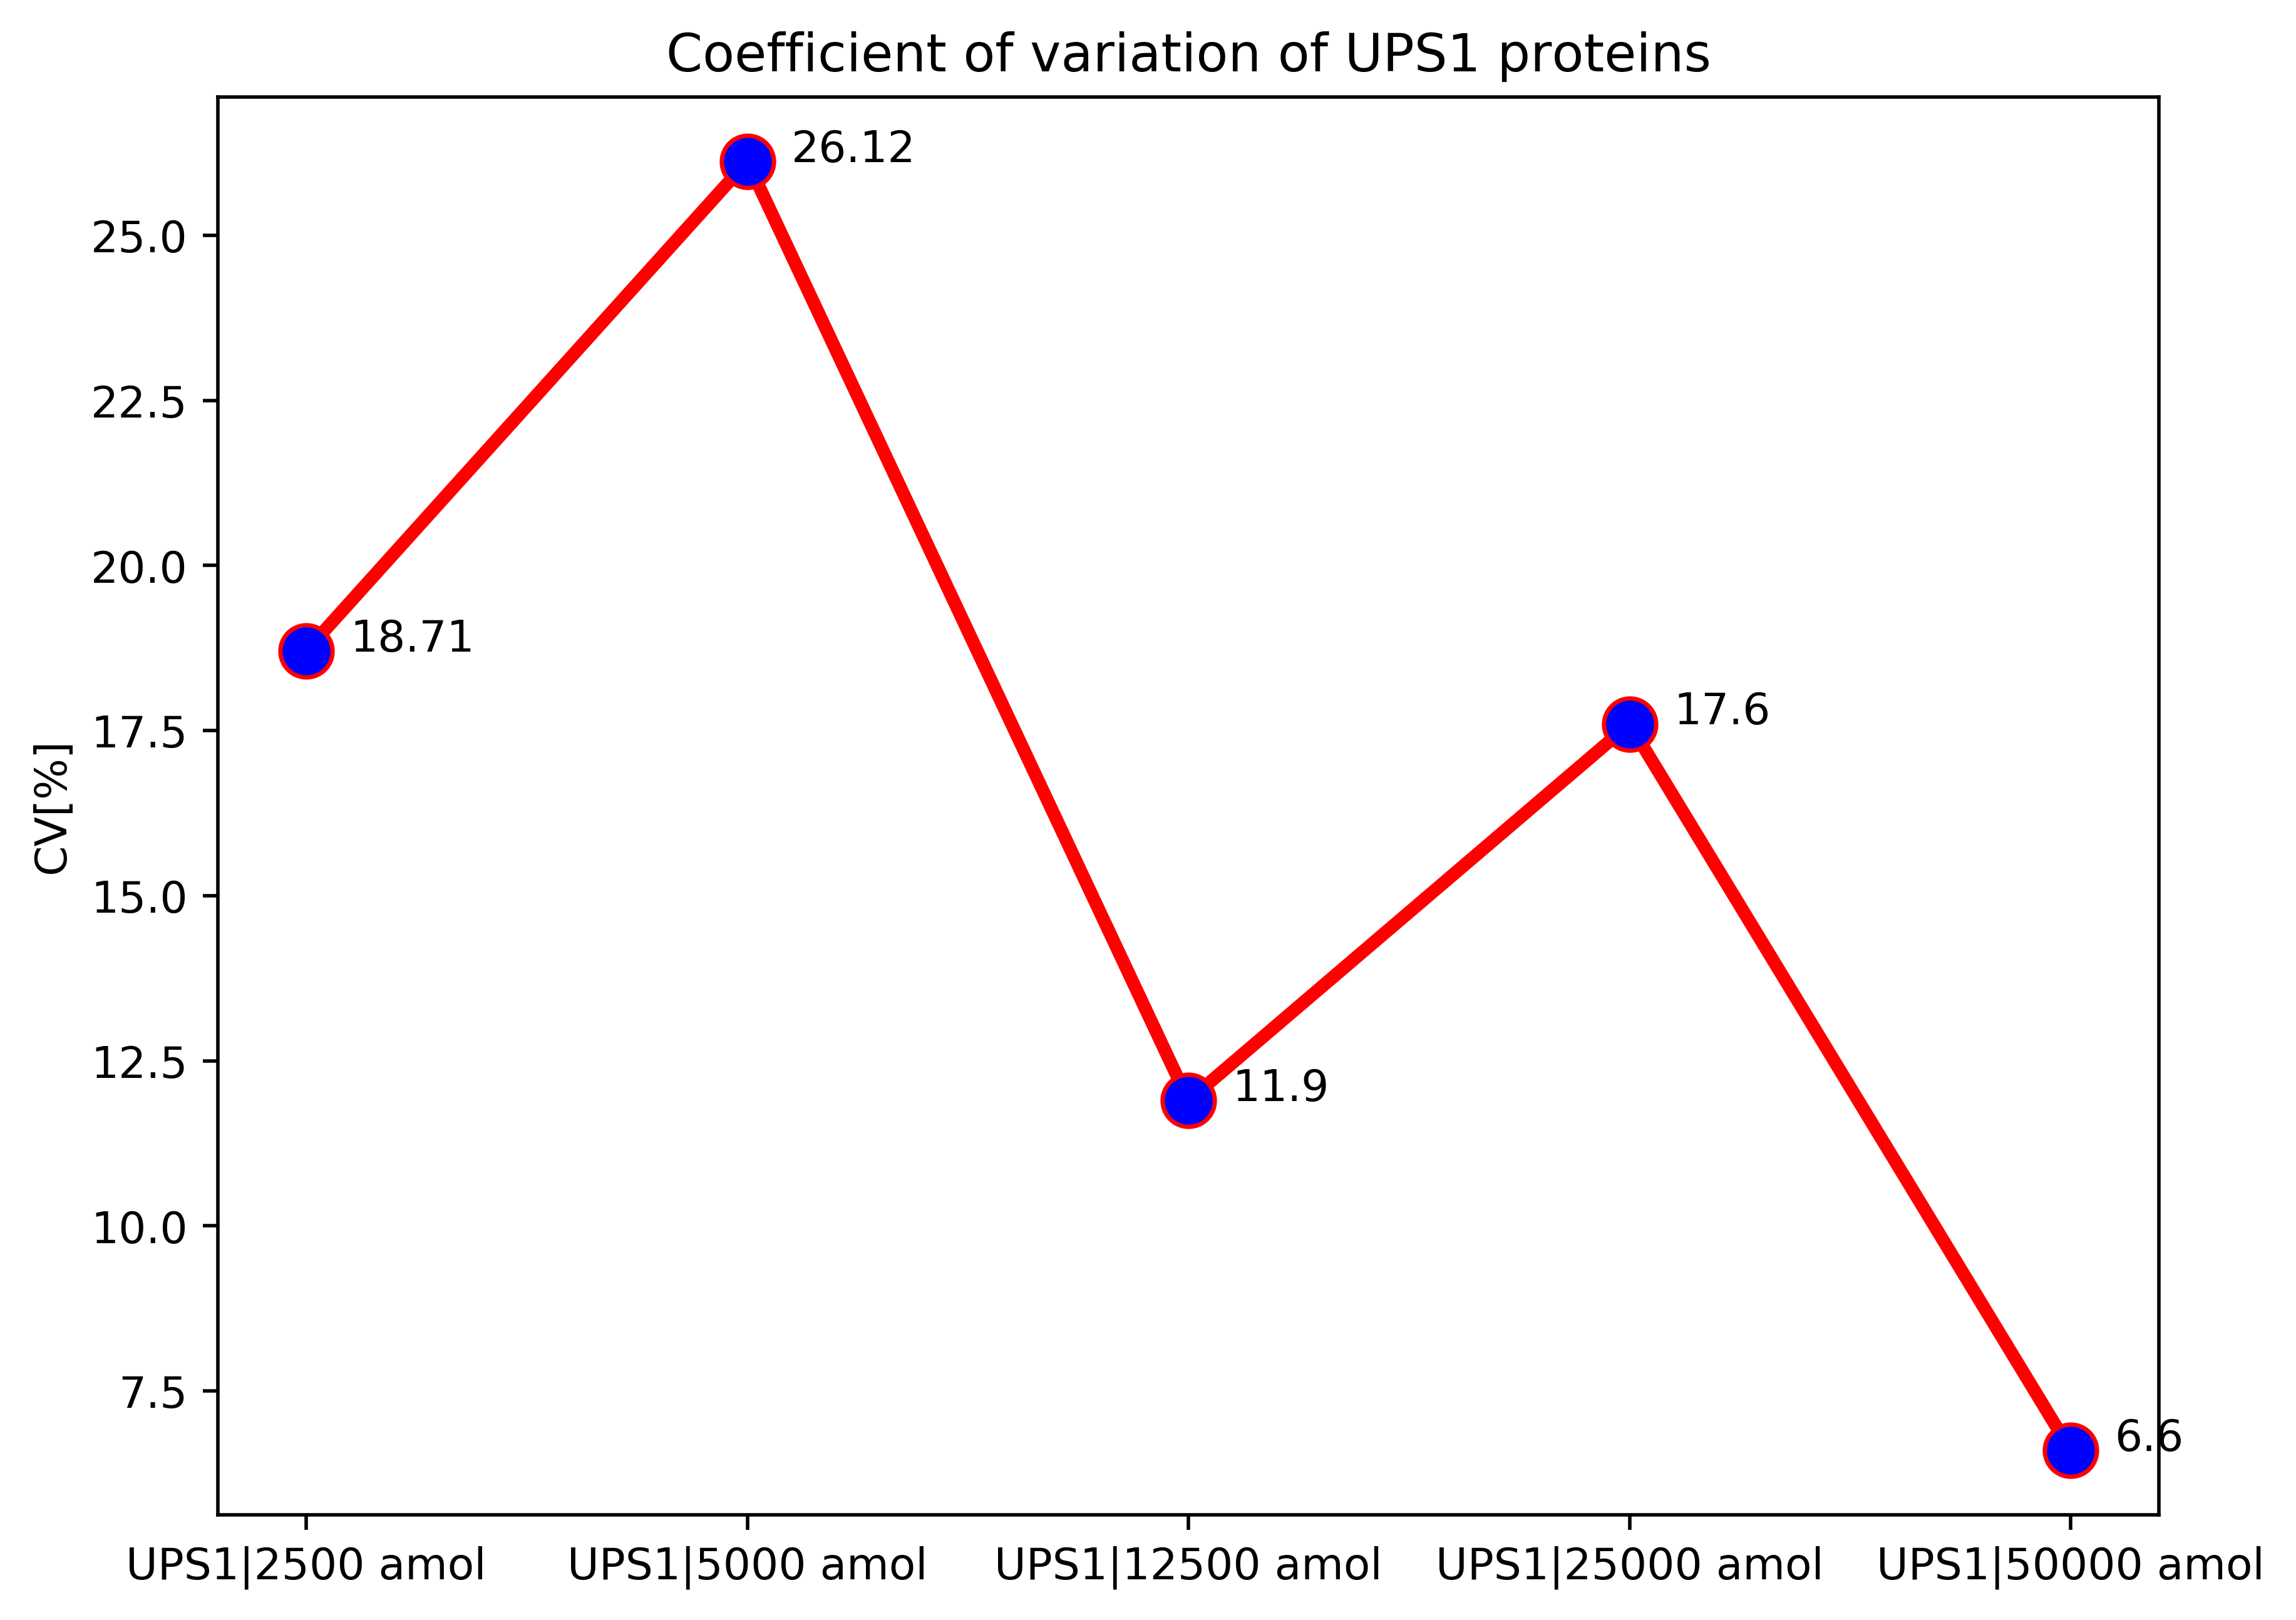

In [8]:
n_data = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]"])
for condition in np.unique(quantms['Condition']):
    if len(quantms.loc[(quantms['ProteinName'].str.contains("ups")) & (quantms['Condition'] == condition)]) < 3:
        continue
    quant_condition = quantms.loc[(quantms['ProteinName'].str.contains("ups")) & (quantms['Condition'] == condition)]
    for protein in np.unique(quant_condition['ProteinName']):
        msruns = np.unique(quant_condition[quant_condition['ProteinName'] == protein]['Run'])
        
        # proteins were filtered out if not quantified in all replicates
        if len(msruns) < 3:
            continue
            
        tech_intensity = []    
        # summarized protein intensity in a technical replicate
        for run in msruns:
            tech_intensity.append(np.sum(quant_condition[(quant_condition['ProteinName'] == protein) & ((quant_condition['Run'] == run))]['Intensity']))
        mean = np.mean(tech_intensity)
        std = np.std(tech_intensity)
        n_data = n_data.append({'ProteinName':protein,'TechRep1':tech_intensity[0], 
                       'TechRep2': tech_intensity[1], 'TechRep3': tech_intensity[2], 
                       'Condition': condition, "CV[%]": 100 * (std / mean)}, ignore_index=True)

# calcualte average CV in UPS1 proteins without missing value
cvs = []
xticks = []
plt.figure(figsize=(8,6), dpi=500)
conditions = np.unique(n_data["Condition"])
conditions = sorted(conditions, key= lambda x: int(x.replace("UPS1|","").replace(" amol", "")))
for condition in conditions:
    cvs.append(np.mean(n_data[n_data['Condition'] == condition]["CV[%]"]))
    xticks.append(condition)
    
plt.plot(range(5), cvs, linewidth=3, color='r', marker='o',markerfacecolor='blue', markersize=12)
plt.xticks(range(5), xticks)
for i in range(5):
    plt.text(i+0.1, cvs[i], round(cvs[i], 2))
plt.ylabel('CV[%]')
plt.title('Coefficient of variation of UPS1 proteins')
plt.show()


#### Calcaulate CV of backgroud Proteins

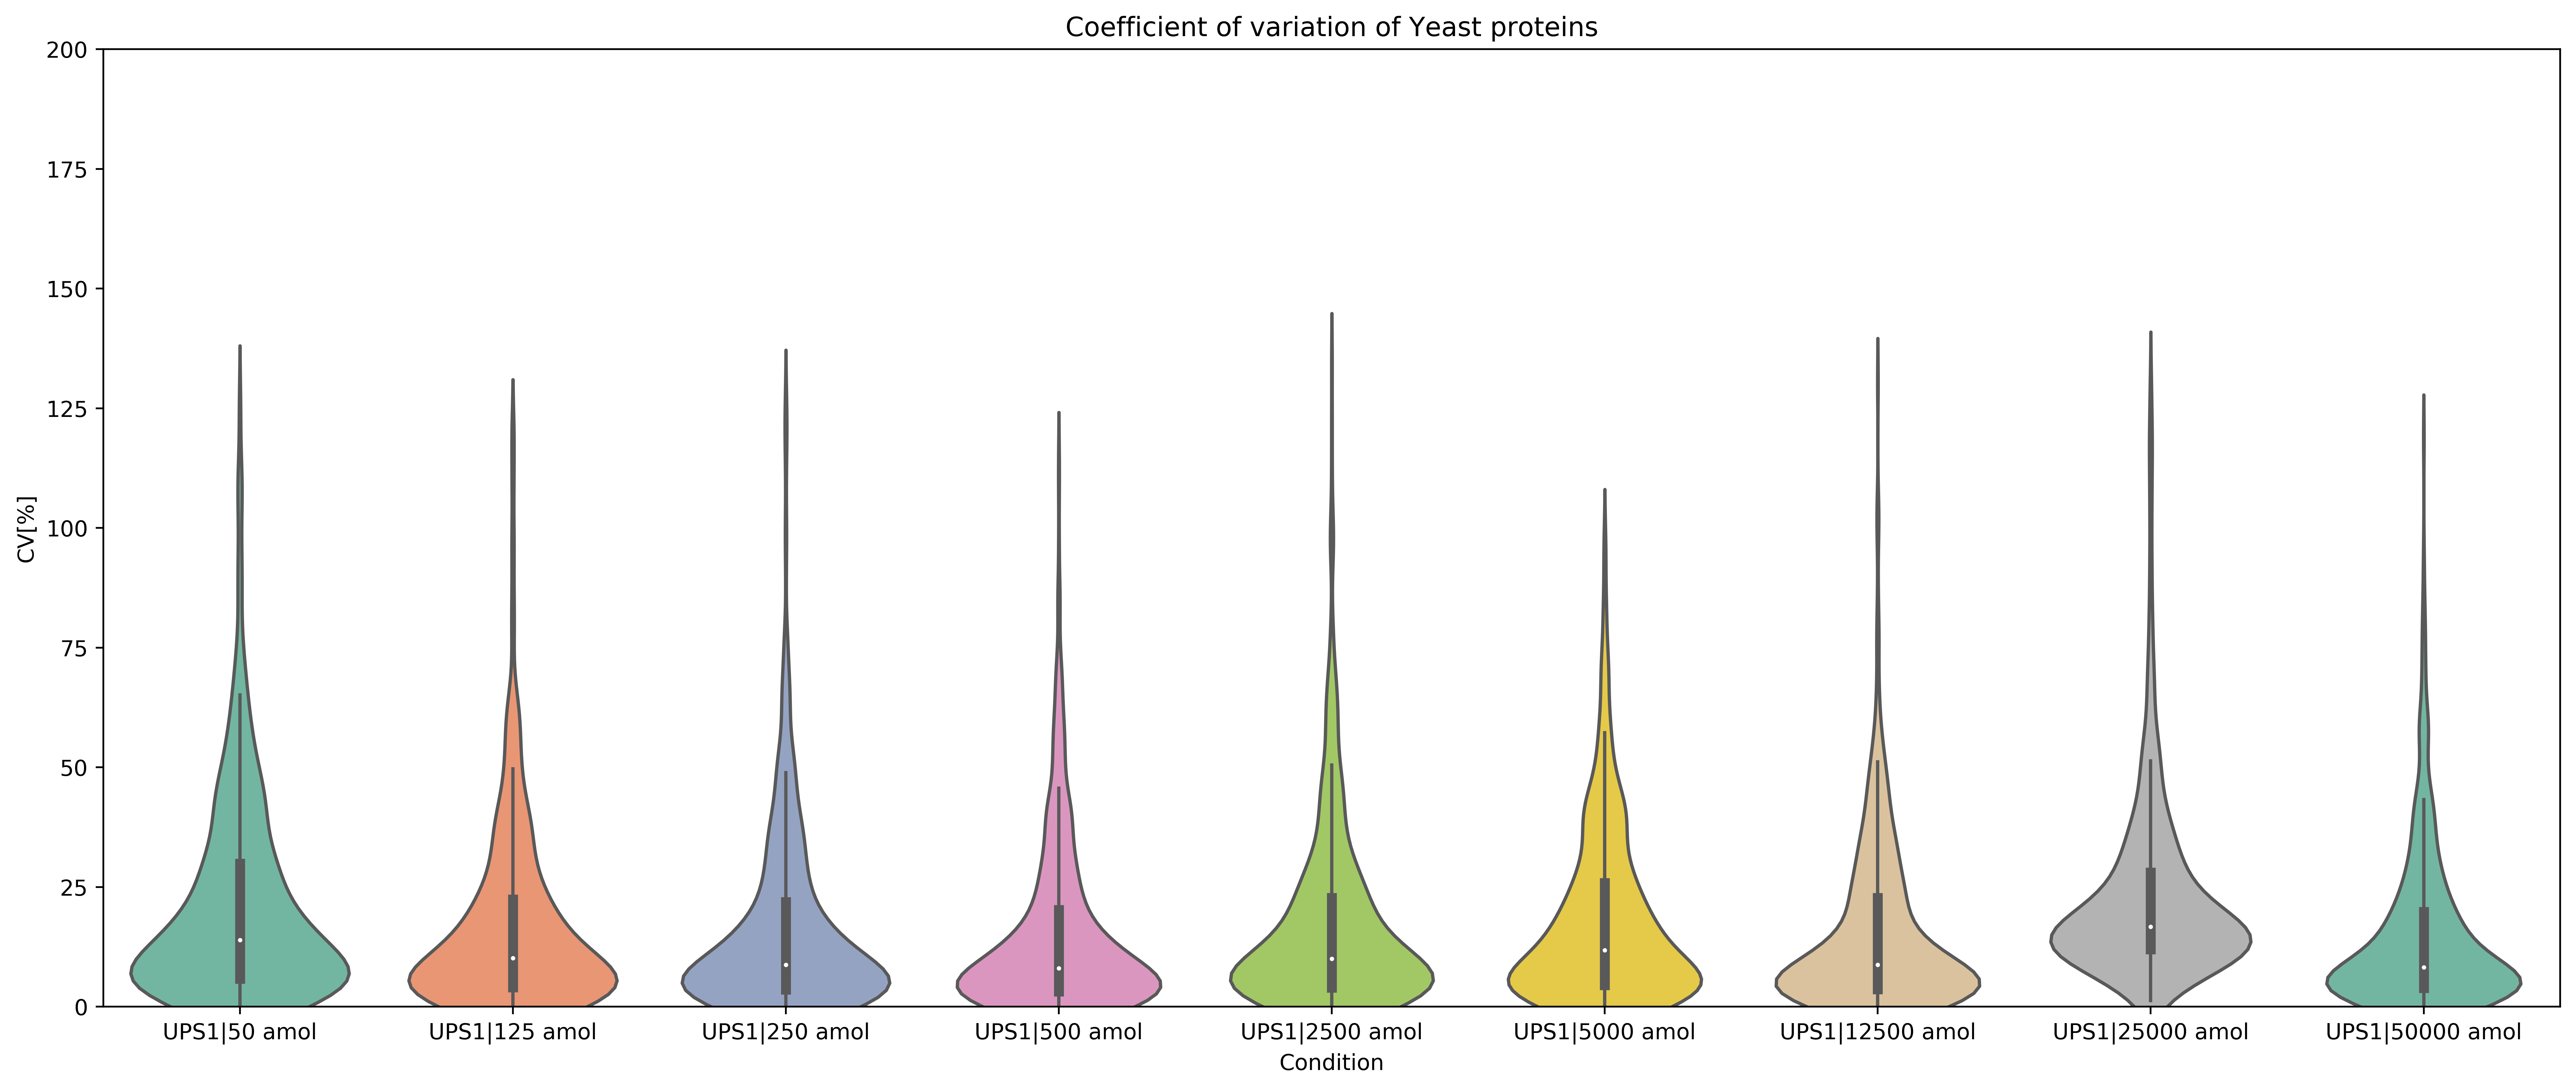

In [9]:
b_data = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]"])
quantms_background = quantms[-quantms['ProteinName'].str.contains("ups")]
for condition in np.unique(quantms_background['Condition']):
    quantms_background_condition = quantms_background.loc[quantms_background['Condition'] == condition]
    for protein in np.unique(quantms_background_condition['ProteinName']):
        msruns = np.unique(quantms_background_condition[quantms_background_condition['ProteinName'] == protein]['Run'])
        
        # proteins were filtered out if not quantified in all replicates
        if len(msruns) < 3:
            continue
            
        tech_intensity = []    
        # summarized protein intensity in a technical replicate
        for run in msruns:
            tech_intensity.append(np.sum(quantms_background_condition[(quantms_background_condition['ProteinName'] == protein) & ((quantms_background_condition['Run'] == run))]['Intensity']))
        mean = np.mean(tech_intensity)
        std = np.std(tech_intensity)
        b_data = b_data.append({'ProteinName':protein,'TechRep1':tech_intensity[0], 
                       'TechRep2': tech_intensity[1], 'TechRep3': tech_intensity[2], 
                       'Condition': condition, "CV[%]": 100 * (std / mean)}, ignore_index=True)

plt.figure(figsize=(20,8), dpi=500)
plt.ylim(0, 200)
plt.title("Coefficient of variation of Yeast proteins")
sns.violinplot(x = "Condition", y="CV[%]", data=b_data, scale= "count", palette="Set2", 
               order=['UPS1|50 amol', 'UPS1|125 amol', 'UPS1|250 amol', 'UPS1|500 amol', 'UPS1|2500 amol', 'UPS1|5000 amol',
                     'UPS1|12500 amol', 'UPS1|25000 amol', 'UPS1|50000 amol'])

plt.show()

### QCplots and Calculate FC

In [10]:
%%R -w 800 -h 600

library('MSstats', warn.conflicts = F, quietly = T, verbose = F)
#library(reticulate)

protein_expression = 'protein_expression.csv'

raw.om <- read.csv('out_msstats.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

# If run dataProcess() occuring an error message, please change "summaryMethod = 'TMP'" to "summaryMethod = 'linear'"
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = 'equalizeMedians',
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP')]
head(Protein.Expression)
write.csv(Protein.Expression, file=protein_expression, row.names=FALSE)

INFO  [2021-11-27 15:17:57] ** Features with one or two measurements across runs are removed.
INFO  [2021-11-27 15:17:57] ** Fractionation handled.
INFO  [2021-11-27 15:17:57] ** Updated quantification data to make balanced design. Missing values are marked by NA
INFO  [2021-11-27 15:17:58] ** Log2 intensities under cutoff = 20.633  were considered as censored missing values.
INFO  [2021-11-27 15:17:58] ** Log2 intensities = NA were considered as censored missing values.
INFO  [2021-11-27 15:17:58] ** Use all features that the dataset originally has.
INFO  [2021-11-27 15:17:58] 
 # proteins: 1040
 # peptides per protein: 1-87
 # features per peptide: 1-1
INFO  [2021-11-27 15:17:58] Some proteins have only one feature: 
 P01133ups|EGF_HUMAN_UPS,
 sp|A5Z2X5|YP010_YEAST,
 sp|O13516|RS9A_YEAST,
 sp|O13563|RPN13_YEAST,
 sp|O13585|YP089_YEAST ...
INFO  [2021-11-27 15:17:58] 
                    UPS1|125 amol UPS1|12500 amol UPS1|250 amol UPS1|2500 amol UPS1|25000 amol UPS1|50 amol UPS1|500 a

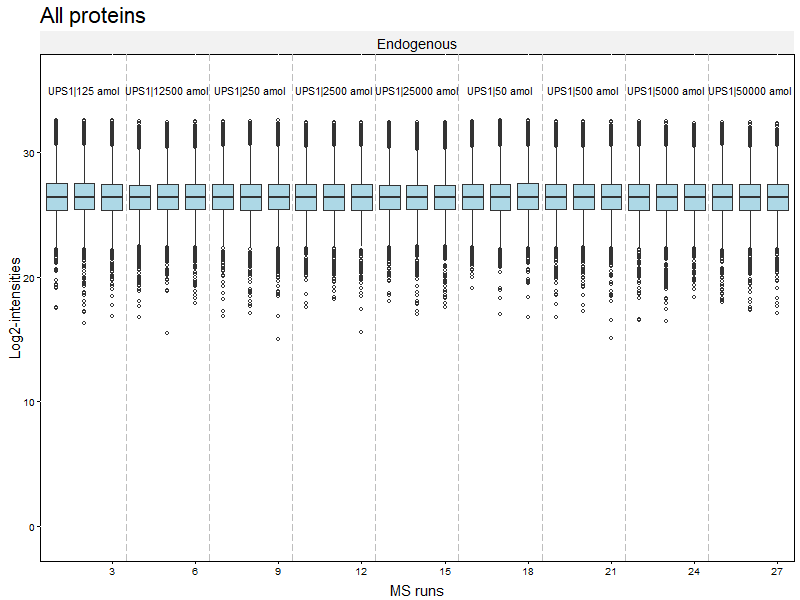

In [11]:
%%R -w 800 -h 600
tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append('allonly', tmp, 1)
dataProcessPlots(data = quantms.proposed, type="QCPlot",which.Protein=selector,width=10, height=5, address=FALSE)

[1] "sp|P24784|DBP1_YEAST"
  |=========================                                             |  36%


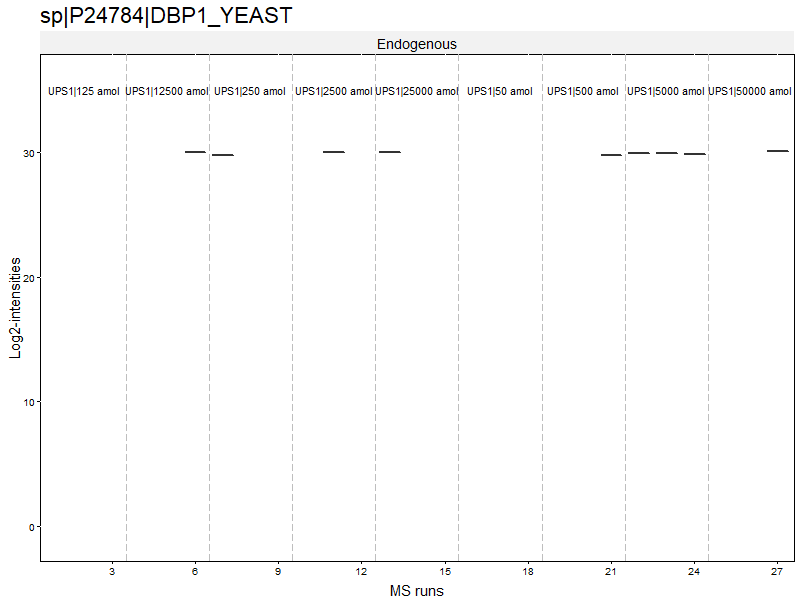

In [12]:
%%R -w 800 -h 600

Protein.Expression2 <- Protein.Expression[order(Protein.Expression$LogIntensities,decreasing = TRUE),]
protein_accession <- as.character(Protein.Expression2$Protein[1])
print(protein_accession)
tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append(protein_accession, tmp, 1)
dataProcessPlots(data = quantms.proposed, type="QCPlot",which.Protein=selector,width=10, height=5, address=FALSE)


#### background proteins: Intensity shoud be identical in all MSrun

  |======================================================================| 100%
  |======================================================================| 100%


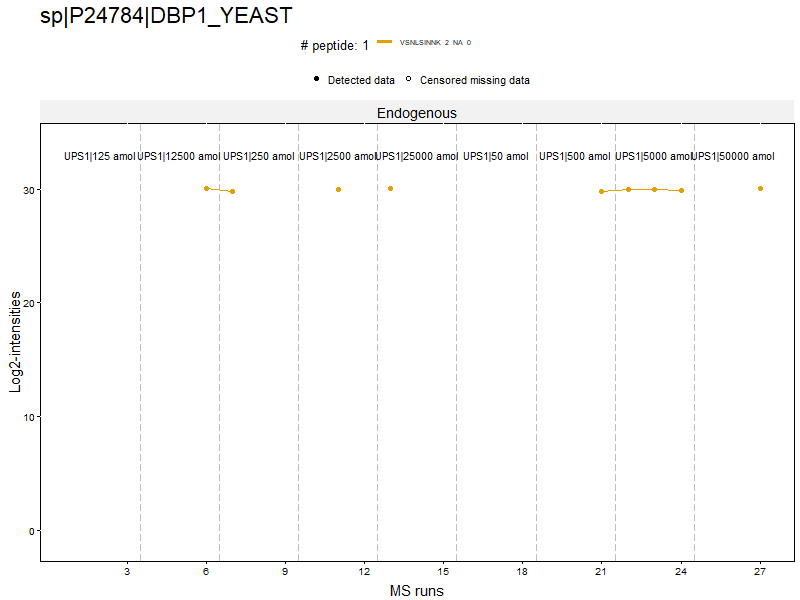

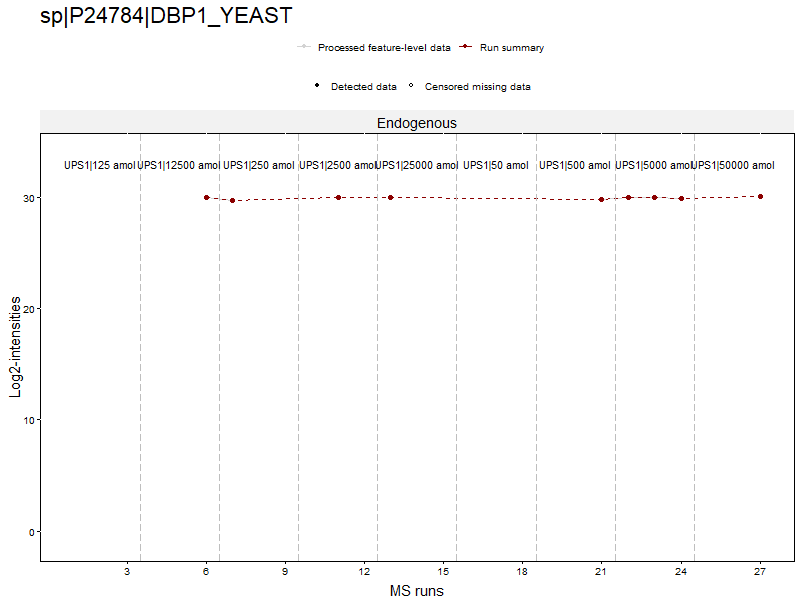

In [13]:
%%R -w 800 -h 600

tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append(protein_accession, tmp, 1)
dataProcessPlots(data = quantms.proposed, type="ProfilePlot",which.Protein=selector,width=10, height=5, address=FALSE)

  |=                                                                     |   2%


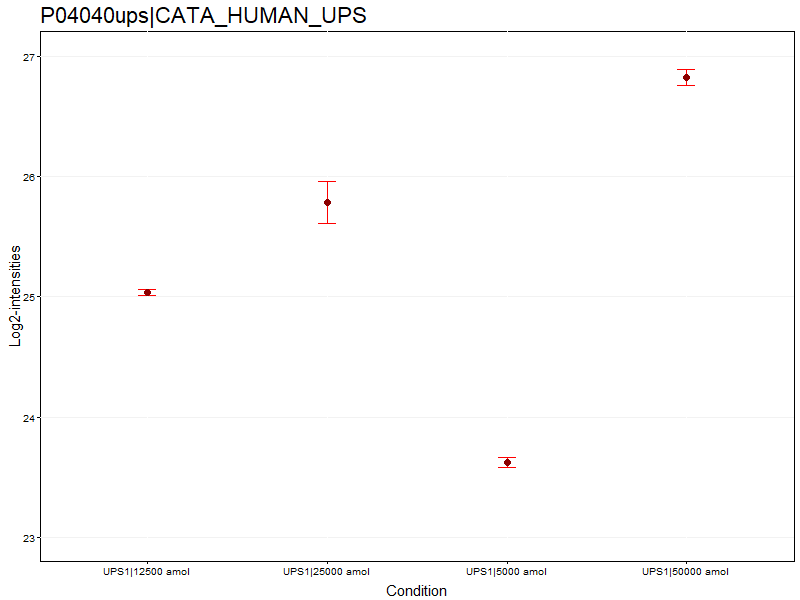

In [14]:
%%R -w 800 -h 600

tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append("P04040ups|CATA_HUMAN_UPS", tmp, 1)
dataProcessPlots(data = quantms.proposed, type="ConditionPlot",which.Protein=selector,width=10, height=5, address=FALSE)

In [15]:
%%R

ac_groups = levels(quantms.proposed$FeatureLevelData$GROUP)
groups = levels(quantms.proposed$ProteinLevelData$GROUP)
print(groups)
comparison_matrix = c(0,0,0,0,0,0,-1,0,0,0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,-1,0,0,-1,0,-1,0,1,
                     0,-1,0,0,0,0,0,0,-1,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                     0,0,0,0,0,-1,0,0,0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,-1,0,0,-1,0,0,1,1,0,
                     0,0,0,-1,0,0,0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,
                     -1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                     0,0,0,0,0,0,0,-1,0,0,0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,-1,0,0,-1,0,-1,-1,
                     0,0,0,0,-1,0,0,0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,-1,0,0,0,1,1,1,0,0,0,
                     0,0,-1,0,0,0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,
                     1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)

print(length(comparison_matrix))
comparison <- matrix(comparison_matrix, nrow=36)
colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- c("50vs25", "50vs12.5", "50vs5","50vs2.5","50vs0.5", "50vs0.25", "50vs0.125","50vs0.05", 
                          "25vs12.5", "25vs5", "25vs2.5", "25vs0.5", "25vs0.25", "25vs0.125", "25vs0.05",
                          "12.5vs5", "12.5vs2.5", "12.5vs0.5", "12.5vs0.25", "12.5vs0.125", "12.5vs0.05",
                          "5vs2.5", "5vs0.5", "5vs0.25", "5vs0.125", "5vs0.05",
                          "2.5vs0.5", "2.5vs0.25", "2.5vs0.125", "2.5vs0.05",
                          "0.5vs0.25", "0.5vs0.125", "0.5vs0.05",
                          "0.25vs0.125", "0.25vs0.05",
                           "0.125vs0.05")

[1] "UPS1|125 amol"   "UPS1|12500 amol" "UPS1|250 amol"   "UPS1|2500 amol" 
[5] "UPS1|25000 amol" "UPS1|50 amol"    "UPS1|500 amol"   "UPS1|5000 amol" 
[9] "UPS1|50000 amol"
[1] 324


In [16]:
%%R

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)
write.csv(ResultComparison$ComparisonResult, 'comparison_res.csv', row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2021-11-27 15:18:20]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2021-11-27 15:18:35]  == Comparisons for all proteins are done.


### Measure Accuracy of protein quantification

#### MAPE (Mean absolute percentage error) of detected UPS1 protein concentrations relative to the corresponding know concentrations for 36 paired comparisions. MAPE(%) = 1/N * (expected FC - experimental FC / expected FC) * 100. N=number of UPS1 quantified proteins

In [17]:
compar_res = pd.read_csv("comparison_res.csv", sep=',', header=0)
compar_res.head()

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage
0,O00762ups|UBE2C_HUMAN_UPS,50vs25,0.904417,0.181832,4.973910,9.0,7.657937e-04,9.212384e-03,NaN,0.212121,0.212121
1,O00762ups|UBE2C_HUMAN_UPS,50vs12.5,1.826174,0.181832,10.043178,9.0,3.452148e-06,4.801275e-05,NaN,0.393939,0.393939
2,O00762ups|UBE2C_HUMAN_UPS,50vs5,3.442121,0.181832,18.930198,9.0,1.473659e-08,4.197200e-07,NaN,0.454545,0.454545
3,O00762ups|UBE2C_HUMAN_UPS,50vs2.5,4.228056,0.203295,20.797677,9.0,6.429011e-09,3.508403e-07,NaN,0.500000,0.333333
4,O00762ups|UBE2C_HUMAN_UPS,50vs0.5,inf,NaN,NaN,NaN,NaN,0.000000e+00,oneConditionMissing,0.530303,0.030303


[16.790364927057592, 12.804092815742791, 14.372793694522379, 25.95887941157193, 93.13299280887908, 96.63481259715829, 98.23873872147203, 99.16415677463624, 11.415236790377254, 14.837221828589614, 31.715558478643008, 97.26780665972827, 98.1584954679796, 98.88949678431322, 99.4729875681181, 14.698376769935422, 29.280233405892123, 97.05111770582457, 98.10928165472431, 99.0716992852533, 99.55945556006894, 24.366171837538566, 92.394256829733, 95.89541878813242, 98.04926650469501, 99.07423878761271, 79.45597500041481, 90.04743511953811, 94.99671535558102, 97.62558705764579, 51.37688223680024, 74.35183582150178, 87.82812945871805, 50.82023394105599, 76.66071764224611, 52.54291708142578]


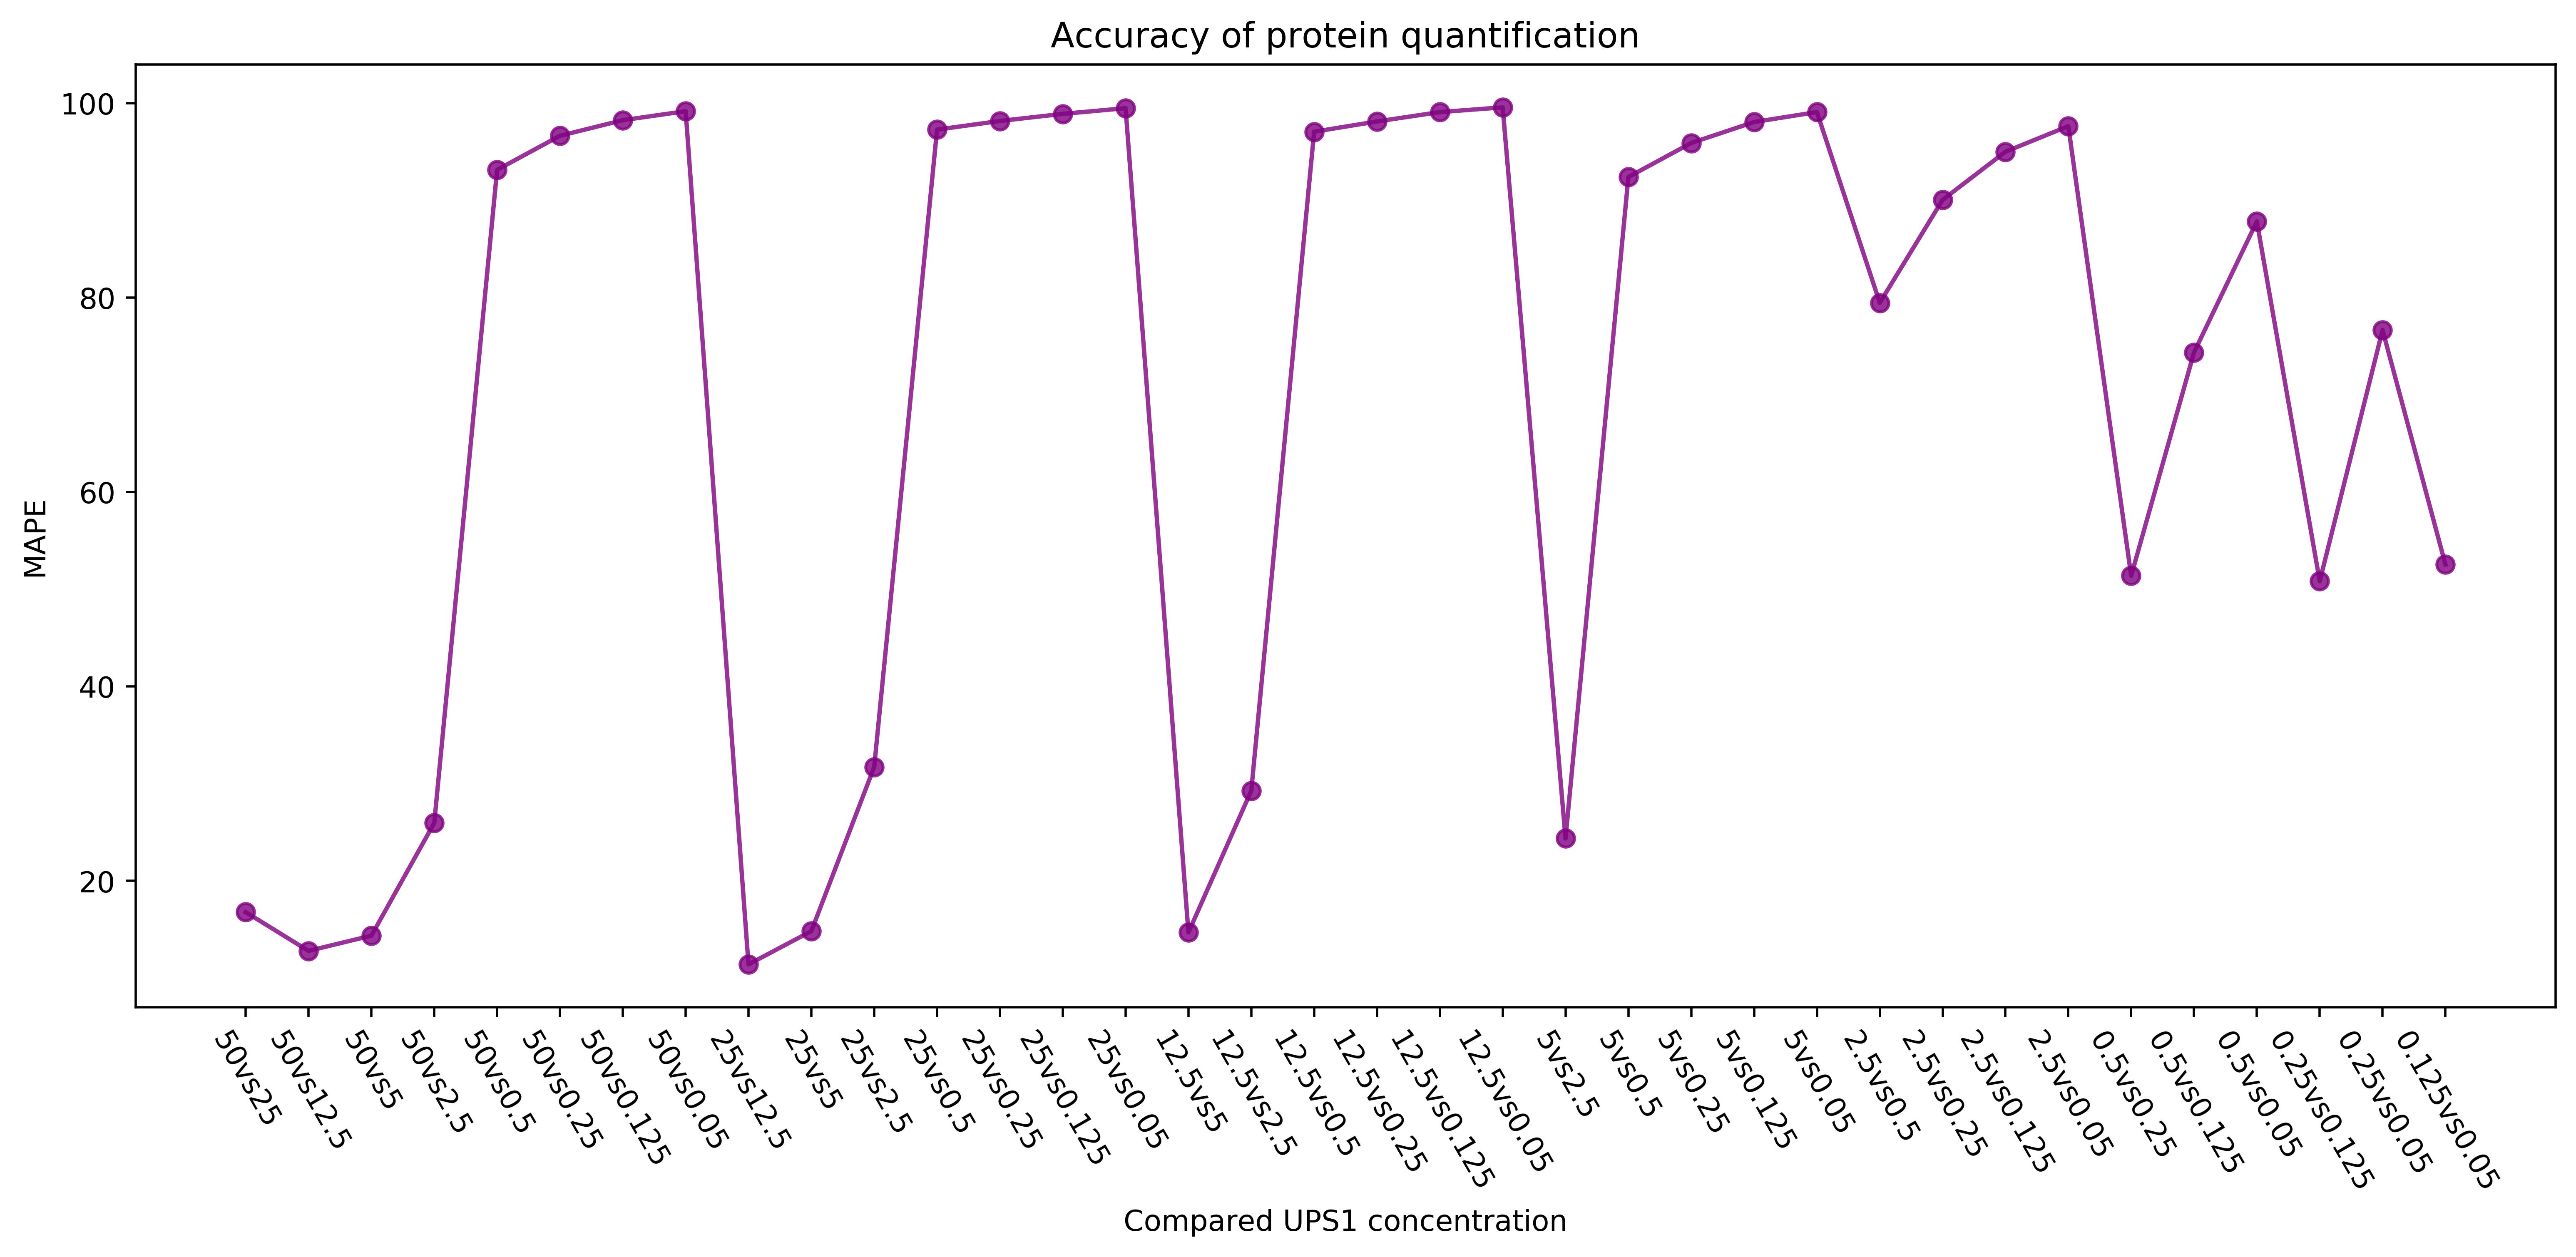

In [18]:
# calculate MAPE
import math

MAPE = []
ups_comp = compar_res[compar_res['Protein'].str.contains("UPS")]
conditions = ["50vs25", "50vs12.5", "50vs5","50vs2.5","50vs0.5", "50vs0.25", "50vs0.125","50vs0.05", 
                          "25vs12.5", "25vs5", "25vs2.5", "25vs0.5", "25vs0.25", "25vs0.125", "25vs0.05",
                          "12.5vs5", "12.5vs2.5", "12.5vs0.5", "12.5vs0.25", "12.5vs0.125", "12.5vs0.05",
                          "5vs2.5", "5vs0.5", "5vs0.25", "5vs0.125", "5vs0.05",
                          "2.5vs0.5", "2.5vs0.25", "2.5vs0.125", "2.5vs0.05",
                          "0.5vs0.25", "0.5vs0.125", "0.5vs0.05",
                          "0.25vs0.125", "0.25vs0.05",
                           "0.125vs0.05"]
for condition in conditions:
    t = ups_comp[ups_comp['Label'] == condition]
    ape = []
    for protein in t['Protein']:
        if "Missing" in str(t[t['Protein'] == protein]['issue'].values[0]):
            continue
        experimental_FC = math.pow(2, t[t['Protein'] == protein]['log2FC'])
        expected_FC = float(condition.split("vs")[0]) / float(condition.split("vs")[1])
        ape.append(np.abs(expected_FC - experimental_FC) / expected_FC * 100)
    MAPE.append(np.mean(ape))

print(MAPE)
plt.figure(figsize=(15,6), dpi=500)
plt.plot(range(36), MAPE, 'ro-', color='purple', alpha=0.8, label='')
plt.xticks(range(36), conditions)
plt.title("Accuracy of protein quantification")
plt.xlabel("Compared UPS1 concentration")
plt.ylabel("MAPE")
plt.xticks(rotation=300)
plt.show()

### Measure Sensitivity and specificity of the differential expression analysis

#### Sensitivity (%) = 100 * TP / (TP+FN) and FDP (%) = 100 * FP / (FP+TP)

#### Total real ups1 differential expressed 48*36 within different comparison. In quantified ups1 proteins, ...

In [19]:
# filtered out missing value
compar_res = pd.read_csv("comparison_res.csv", sep=',', header=0)
compar_res = compar_res.query('issue != issue')
compar_res

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage
0,O00762ups|UBE2C_HUMAN_UPS,50vs25,0.904417,0.181832,4.973910,9.0,7.657937e-04,9.212384e-03,NaN,0.212121,0.212121
1,O00762ups|UBE2C_HUMAN_UPS,50vs12.5,1.826174,0.181832,10.043178,9.0,3.452148e-06,4.801275e-05,NaN,0.393939,0.393939
2,O00762ups|UBE2C_HUMAN_UPS,50vs5,3.442121,0.181832,18.930198,9.0,1.473659e-08,4.197200e-07,NaN,0.454545,0.454545
3,O00762ups|UBE2C_HUMAN_UPS,50vs2.5,4.228056,0.203295,20.797677,9.0,6.429011e-09,3.508403e-07,NaN,0.500000,0.333333
8,O00762ups|UBE2C_HUMAN_UPS,25vs12.5,0.921756,0.181832,5.069268,9.0,6.725380e-04,9.263669e-03,NaN,0.545455,0.545455
9,O00762ups|UBE2C_HUMAN_UPS,25vs5,2.537703,0.181832,13.956288,9.0,2.106993e-07,7.234008e-06,NaN,0.606061,0.606061
10,O00762ups|UBE2C_HUMAN_UPS,25vs2.5,3.323639,0.203295,16.348877,9.0,5.328778e-08,3.977206e-06,NaN,0.651515,0.484848
15,O00762ups|UBE2C_HUMAN_UPS,12.5vs5,1.615947,0.181832,8.887021,9.0,9.466481e-06,3.146658e-04,NaN,0.787879,0.787879
16,O00762ups|UBE2C_HUMAN_UPS,12.5vs2.5,2.401883,0.203295,11.814786,9.0,8.789833e-07,6.035686e-05,NaN,0.833333,0.666667
21,O00762ups|UBE2C_HUMAN_UPS,5vs2.5,0.785936,0.203295,3.865993,9.0,3.812016e-03,1.832010e-01,NaN,0.893939,0.727273


In [20]:
from sklearn import metrics
# calculate z-score: (FC-FC average) / FC std
FC_Average = np.mean(compar_res['log2FC'])
FC_Std = np.std(compar_res['log2FC'])

compar_res['Z-Score'] = compar_res.apply(lambda x: (x['log2FC'] - FC_Average) / FC_Std, axis=1)

conditions = ["50vs25", "50vs12.5", "50vs5","50vs2.5","25vs12.5", "25vs5", "25vs2.5","12.5vs5", "12.5vs2.5","5vs2.5"]
# conditions = ["50vs25", "50vs12.5", "50vs5","50vs2.5","50vs0.5", "50vs0.25", "50vs0.125","50vs0.05", 
#                           "25vs12.5", "25vs5", "25vs2.5", "25vs0.5", "25vs0.25", "25vs0.125", "25vs0.05",
#                           "12.5vs5", "12.5vs2.5", "12.5vs0.5", "12.5vs0.25", "12.5vs0.125", "12.5vs0.05",
#                           "5vs2.5", "5vs0.5", "5vs0.25", "5vs0.125", "5vs0.05",
#                           "2.5vs0.5", "2.5vs0.25", "2.5vs0.125", "2.5vs0.05",
#                           "0.5vs0.25", "0.5vs0.125", "0.5vs0.05",
#                           "0.25vs0.125", "0.25vs0.05",
#                            "0.125vs0.05"]
data = pd.DataFrame(columns=['value', 'metrics', 'label', 'value2'])
for condition in conditions:
    group = compar_res[compar_res['Label'] == condition]
    differential_proteins = group[(group['adj.pvalue'] < 0.05) & (np.abs(group['Z-Score']) > 1.96)]
    FN = len(group[((group['adj.pvalue'] >= 0.05) | (np.abs(group['Z-Score']) <= 1.96 )) & (group['Protein'].str.contains("ups"))])
    TP = len(differential_proteins[differential_proteins['Protein'].str.contains("ups")]['Protein'])
    FP = len(differential_proteins[-differential_proteins['Protein'].str.contains("ups")]['Protein'])
    
    if TP + FP == 0:
        data = data.append({"value": 0, "metrics": "Sensitivity", "Label": condition, 'value2': 0}, ignore_index=True)
        data = data.append({"value": 0, "metrics": "FDP", "Label": condition, 'value2': 0}, ignore_index=True)
        continue
    Sensitivity = TP / (TP+FN) * 100
    FDP = FP / (FP + TP) * 100
    data = data.append({"value": Sensitivity, "metrics": "Sensitivity", "Label": condition, 'value2': Sensitivity}, ignore_index=True)
    data = data.append({"value": FDP, "metrics": "FDP", "Label": condition, 'value2': -FDP},ignore_index=True)
    
data.to_csv("./test1.csv", sep=',', index=False)

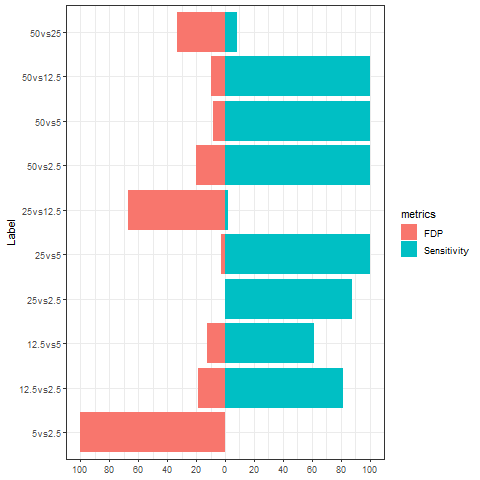

In [21]:
%%R 

library(ggplot2)
data = read.csv("test1.csv", sep=',',header = TRUE)
# conditions = c("50vs25", "50vs12.5", "50vs5","50vs2.5","50vs0.5", "50vs0.25", "50vs0.125","50vs0.05", 
#                           "25vs12.5", "25vs5", "25vs2.5", "25vs0.5", "25vs0.25", "25vs0.125", "25vs0.05",
#                           "12.5vs5", "12.5vs2.5", "12.5vs0.5", "12.5vs0.25", "12.5vs0.125", "12.5vs0.05",
#                           "5vs2.5", "5vs0.5", "5vs0.25", "5vs0.125", "5vs0.05",
#                           "2.5vs0.5", "2.5vs0.25", "2.5vs0.125", "2.5vs0.05",
#                           "0.5vs0.25", "0.5vs0.125", "0.5vs0.05",
#                           "0.25vs0.125", "0.25vs0.05",
#                            "0.125vs0.05")
conditions = c("50vs25", "50vs12.5", "50vs5","50vs2.5","25vs12.5", "25vs5", "25vs2.5","12.5vs5", "12.5vs2.5","5vs2.5")

conditions = rev(conditions)
data$Label <- factor(data$Label,levels=conditions)

ggplot(data = data) + geom_col(aes(x = Label, y = value2, fill = metrics)) + 
   scale_y_continuous(breaks = seq(from = -100, to = 100,by = 20),labels = c(seq(100, 0, -20), seq(20, 100, 20))) + 
   coord_flip() + theme_bw() + ylab(NULL)

# ggsave("sensitivity.png", dpi = 500)